In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import io
import requests
import pandas as pd
from pathlib import Path

In [2]:
### This is the local file path, but we decided to use an S3 bucket instead
# readpath = Path.cwd() / 'Data' / 'heart_failure_clinical_records_dataset.csv'
url="https://final-project-heart.s3.amazonaws.com/heart_failure_clinical_records_dataset.csv"
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Formatting Dataset for Models

In [3]:
target = df["DEATH_EVENT"]
target_names = ["living", "deceased"]
data = df.drop("DEATH_EVENT", axis=1)
feature_names = data.columns
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=3)

### Random Forest Classifier

In [5]:
train = []
test = []
for x in range(300):
    RF_classifier = RandomForestClassifier(n_estimators=x+1)
    RF_classifier.fit(X_train, y_train)
    train.append(RF_classifier.score(X_train, y_train))
    test.append(RF_classifier.score(X_test, y_test))
    print(f"Number of Estimators: {x+1}")

Number of Estimators: 1
Number of Estimators: 2
Number of Estimators: 3
Number of Estimators: 4
Number of Estimators: 5
Number of Estimators: 6
Number of Estimators: 7
Number of Estimators: 8
Number of Estimators: 9
Number of Estimators: 10
Number of Estimators: 11
Number of Estimators: 12
Number of Estimators: 13
Number of Estimators: 14
Number of Estimators: 15
Number of Estimators: 16
Number of Estimators: 17
Number of Estimators: 18
Number of Estimators: 19
Number of Estimators: 20
Number of Estimators: 21
Number of Estimators: 22
Number of Estimators: 23
Number of Estimators: 24
Number of Estimators: 25
Number of Estimators: 26
Number of Estimators: 27
Number of Estimators: 28
Number of Estimators: 29
Number of Estimators: 30
Number of Estimators: 31
Number of Estimators: 32
Number of Estimators: 33
Number of Estimators: 34
Number of Estimators: 35
Number of Estimators: 36
Number of Estimators: 37
Number of Estimators: 38
Number of Estimators: 39
Number of Estimators: 40
Number of

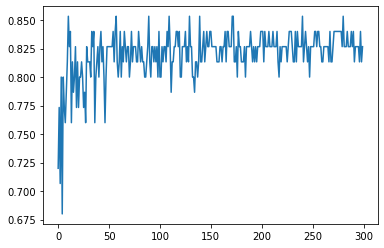

In [18]:
fig1 = plt.plot(test)
test_df = pd.DataFrame(data=test)
test_df.to_csv('./Data/random_forest_sensitivity.csv')
plt.savefig("./Visuals/random_forest_sensitivity.png")

### Sensitivity Study
Iterated over 0 to 300 estimators to find the what would yield the best model. It appears to reach a limit around 50 estimators, but we chose to go after the spike at 88 estimators for our model using all features. 

In [7]:
rf = RandomForestClassifier(n_estimators=88)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8266666666666667

In [8]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.3574468333373579, 'time'),
 (0.1430073950325002, 'serum_creatinine'),
 (0.10937779887635947, 'ejection_fraction'),
 (0.09569921874597548, 'age'),
 (0.07932592922392954, 'creatinine_phosphokinase'),
 (0.07859221168375395, 'serum_sodium'),
 (0.07788765138572912, 'platelets'),
 (0.01519254828167398, 'smoking'),
 (0.012122765257945207, 'anaemia'),
 (0.011899475255345298, 'diabetes'),
 (0.010495092349923931, 'high_blood_pressure'),
 (0.008953080569505943, 'sex')]

### All Features Classification Report

In [9]:
predictions = rf.predict(X_test)
report = classification_report(y_test, predictions, target_names=target_names, output_dict=True)
rf_report = pd.DataFrame(report).T
rf_report.to_html('./templates/random_forest_all_features_report.html')
rf_report.to_csv('./Data/random_forest_all_features_report.csv')
rf_report.head()

,precision,recall,f1-score,support
living,0.877551,0.860000,0.868687,50.000000
deceased,0.730769,0.760000,0.745098,25.000000
accuracy,0.826667,0.826667,0.826667,0.826667
macro avg,0.804160,0.810000,0.806892,75.000000
weighted avg,0.828624,0.826667,0.827491,75.000000


### Using only patient-known factors

In [10]:
patient_known_data = df.drop(["time","creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "DEATH_EVENT"], axis=1)
feature_names = patient_known_data.columns
patient_known_data.head()

,age,anaemia,diabetes,high_blood_pressure,sex,smoking
0,75.0,0,0,1,1,0
1,55.0,0,0,0,1,0
2,65.0,0,0,0,1,1
3,50.0,1,0,0,1,0
4,65.0,1,1,0,0,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(patient_known_data, target, random_state=5)

In [12]:
rf = RandomForestClassifier(n_estimators=88)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.6666666666666666

In [13]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.7171938104855298, 'age'),
 (0.06019362749254282, 'smoking'),
 (0.05731397086398282, 'diabetes'),
 (0.05593933263729511, 'anaemia'),
 (0.0548746022387162, 'high_blood_pressure'),
 (0.05448465628193324, 'sex')]

### Patient-known Features Classification Report

In [14]:
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

      living       0.75      0.79      0.77        53
    deceased       0.42      0.36      0.39        22

    accuracy                           0.67        75
   macro avg       0.59      0.58      0.58        75
weighted avg       0.65      0.67      0.66        75



In [15]:
predictions = rf.predict(X_test)
report = classification_report(y_test, predictions, target_names=target_names, output_dict=True)
rf_report = pd.DataFrame(report).T
rf_report.to_html('./templates/random_forest_patient_known_features_report.html')
rf_report.to_csv('./Data/random_forest_patient_known_features_report.csv')
rf_report.head()

,precision,recall,f1-score,support
living,0.750000,0.792453,0.770642,53.000000
deceased,0.421053,0.363636,0.390244,22.000000
accuracy,0.666667,0.666667,0.666667,0.666667
macro avg,0.585526,0.578045,0.580443,75.000000
weighted avg,0.653509,0.666667,0.659059,75.000000


In [16]:
classification_report(y_test, predictions, target_names=target_names)

'              precision    recall  f1-score   support\n\n      living       0.75      0.79      0.77        53\n    deceased       0.42      0.36      0.39        22\n\n    accuracy                           0.67        75\n   macro avg       0.59      0.58      0.58        75\nweighted avg       0.65      0.67      0.66        75\n'